### Board Game Ranking: Exploratory Data Analysis

#### Context: 

Board games have long been a part of human culture with the historical records dating back as early as 2000 B.C. In recent years, board games have experienced a resurgence in popularity. Tabletop gaming is now a burgeoning industry which had an estimated market of approximately 7.2 billion USD in 2017 and is expected to increase by 4.8 billion USD by 2023. The US card and board game market alone is predicted to increase to 5 billion USD by 2025. Understanding what makes a game popular is important for game developers to determine what kinds of games they should focus on producing.

I've scraped ranking data from https://www.boardgamegeek.com/browse/boardgame for 19,019 games which will be used in this analysis. This data is current as of 6/12/20.

In [250]:
# import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
%matplotlib inline

bgg = pd.read_csv('bgg_clean_impute.csv', index_col=0)

In [251]:
# KNN was used to impute missing values. I'm rounding these columns to remove inconsistencies with age which 
# is reported as a whole number as well as with player count which must be a whole number
bgg.age = bgg.age.round()
bgg.min_players = bgg.min_players.round()
bgg.max_players = bgg.max_players.round()

In [55]:
bgg.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,19019.0,6.386327,0.926332,1.050,5.800,6.420,7.000,9.690
geek_rating,19019.0,5.690209,0.370863,3.537,5.511,5.551,5.689,8.573
num_voters,19019.0,813.651349,3331.557546,30.000,55.000,120.000,379.500,94727.000
rank,19019.0,9511.235817,5491.270778,1.000,4755.500,9512.000,14266.500,19021.000
game_id,19019.0,99563.504969,93033.632027,1.000,9856.500,69105.000,180423.000,310100.000
age,19019.0,10.242337,2.710194,1.000,8.000,10.000,12.000,25.000
max_play_time,19019.0,99.528366,1033.539496,1.000,30.000,45.000,90.000,120000.000
max_players,19019.0,5.549293,9.087904,1.000,4.000,4.000,6.000,362.000
min_play_time,19019.0,68.703549,476.215933,1.000,20.000,30.000,60.000,60000.000
min_players,19019.0,2.036490,0.674595,1.000,2.000,2.000,2.000,10.000


I first want to investigate the distribution of ratings. Geek rating is what determines a games placement on the Geek Charts and this is based on an altered average rating. As found in the FAQ (https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ), Bayseian averaging is used to prevent games with few votes from skewing the data. The exact algorithm is unknown, but it is believed by the community that every game receives approximately 100 dummy votes with a 5.5 value.

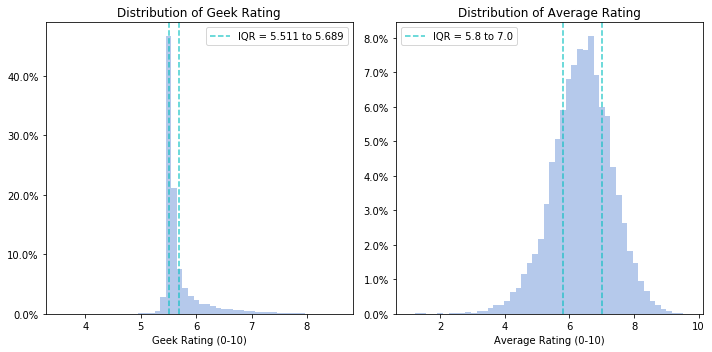

In [291]:
_ = plt.subplots(figsize=(10,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(bgg.geek_rating, hist_kws={'weights': (np.ones(len(bgg.geek_rating)) / len(bgg.geek_rating))}, kde=False)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.25), label='IQR = 5.511 to 5.689', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Geek Rating (0-10)')
_ = plt.title('Distribution of Geek Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

_ = plt.subplot(1,2,2)
_ = sns.distplot(bgg.avg_rating, hist_kws={'weights': (np.ones(len(bgg.avg_rating)) / len(bgg.avg_rating))}, kde=False)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.25), label='IQR = 5.8 to 7.0', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Average Rating (0-10)')
_ = plt.title('Distribution of Average Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()

The left chart shows the distribution of the geek rating. We can clearly see the bayseian averaging in effect with the majority of games having a score between 5 and 6 as well as an incredible right skew.

In comparison, avg rating, representing raw user rating, in the right chart shows more distribution among values. Avg rating does not show the same skew and peaks around a rating of 7. So, users tend to rate games positively (>5).

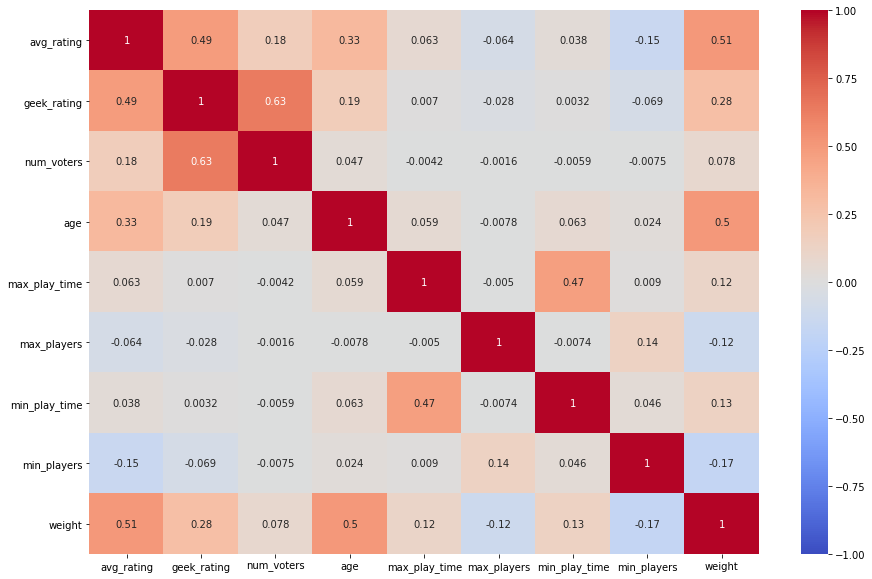

In [81]:
corr = bgg.drop(columns=['rank','game_id']).corr()
fig = plt.subplots(figsize=(15,10))
ax =  sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

In examining the correlation between variables we can see that the number of votes shows the higest correlation with geek rating. In essence, the Baseian averaging represents a hurdle to overcome and a game needs to be popular by average rating before it can have a good geek rating.

So, we'll also want to look further at number of voters, age, and weight as they show correlation to both geek rating and avg rating.

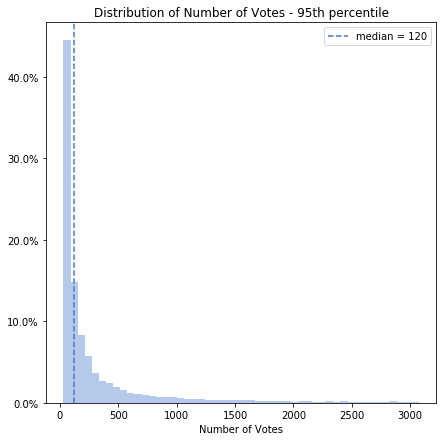

In [278]:
# Num_voters includes significant outliers. Incredibly popular games receive a high 
# volume of votes while the average is much lower so I've only plotted the 95th percentile
bgg_votes = bgg[['num_voters']]
p95 = bgg_votes.quantile(0.95)
bgg_votes95 = bgg_votes[(bgg_votes < p95).any(axis=1)]

_ = plt.figure(figsize=(7,7))
_ = sns.distplot(bgg_votes95, kde=False, hist_kws={'weights' : (np.ones(len(bgg_votes95)) / len(bgg_votes95))})
_ = plt.axvline(x=bgg.num_voters.median(), label='median = 120', linestyle='--')
_ = plt.xlabel('Number of Votes')
_ = plt.title('Distribution of Number of Votes - 95th percentile')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

While the max number of votes for a game is 94,727, the median is 120. This explains why the geek rating rarely deviates from the 5.5 range.

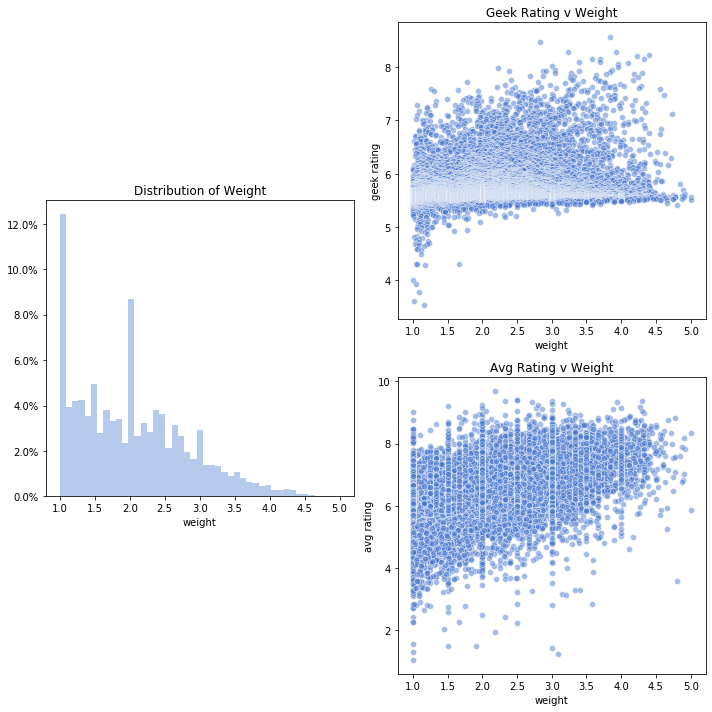

In [523]:
fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(8, 2)

ax = fig.add_subplot(gs[2:6, 0])
_ = sns.distplot(bgg.weight, kde=False, hist_kws={'weights' : (np.ones(len(bgg.weight)) / len(bgg.weight))})
_ = plt.title('Distribution of Weight')
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax = fig.add_subplot(gs[0:4, 1])
_ = sns.scatterplot(x='weight', y='geek_rating', data=bgg, alpha=.5)
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Weight')

ax = fig.add_subplot(gs[4:8, 1])
_ = sns.scatterplot(x='weight', y='avg_rating', data=bgg, alpha=.5)
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Weight')

Weight is a user generated number between 1 and 5 representing the complexity of a game. As this is an average, it is biased towards whole and half numbers (e.g. 2.0 or 3.5) due to the volume of games with minimal number of user values recorded. The scatter plots help illuminate how the Bayseian averaging affects correlation with geek rating.

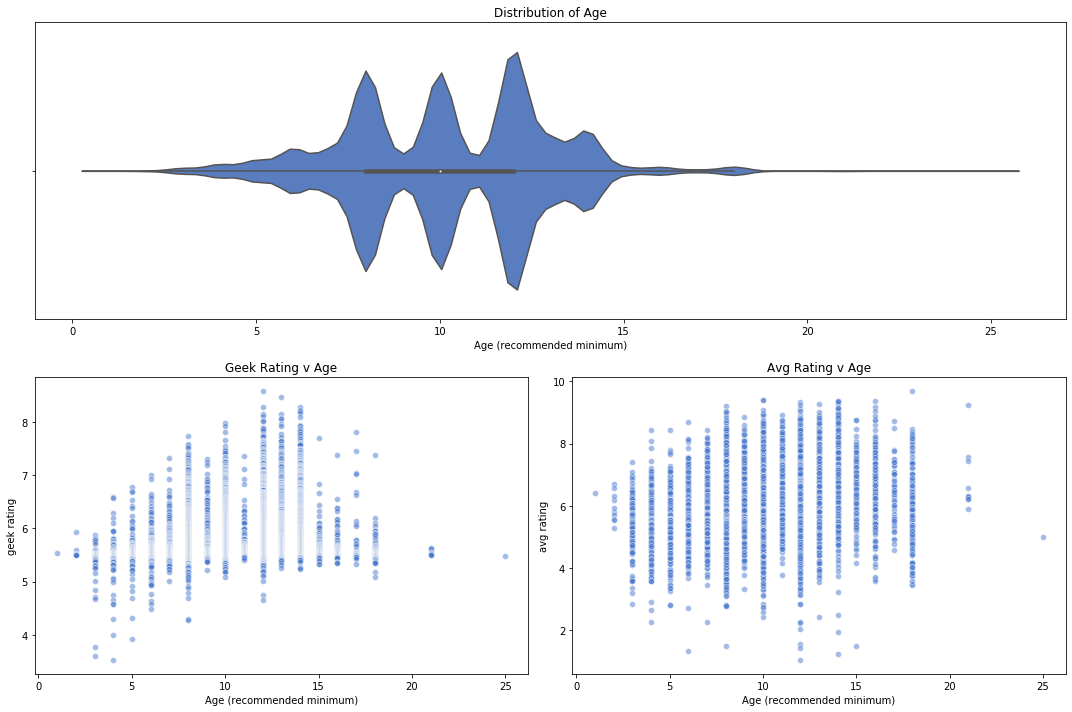

In [524]:
fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,:])
_ = sns.violinplot('age', data=bgg)
_ = plt.title('Distribution of Age')
_ = plt.xlabel("Age (recommended minimum)")

ax = fig.add_subplot(gs[1,0])
_ = sns.scatterplot(x='age', y='geek_rating', data=bgg, alpha=.5)
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")

ax = fig.add_subplot(gs[1,1])
_ = sns.scatterplot(x='age', y='avg_rating', data=bgg, alpha=.5)
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")

In [143]:
# max players, min play time, and max play time feature significant outliers.  
# they are not bad data points, but I remove them here and only plot the IQR for the sake of visualization.
#bgg_boxplot = bgg[['max_players','min_play_time','max_play_time']]
#Q1 = bgg_boxplot.quantile(0.25)
#Q3 = bgg_boxplot.quantile(0.75)
#IQR = Q3 - Q1
#bgg_boxplot = bgg_boxplot[~((bgg_boxplot < (Q1 - 1.5 * IQR)) |(bgg_boxplot > (Q3 + 1.5 * IQR))).any(axis=1)]

In [353]:
#_ = plt.subplots(figsize=(15,5))
#_ = plt.subplot(2,1,1)
#_ = sns.violinplot('min_players', data=bgg)
#_ = plt.title('Distribution of Minimum Players - IQR')
#_ = plt.xlabel("Minumum Players")

#_ = plt.subplot(2,1,2)
#_ = sns.violinplot('max_players',data=bgg_boxplot, color='r')
#_ = plt.title('Distribution of Maximum Players - IQR')
#_ = plt.xlabel("Maximum Players")

#plt.tight_layout()
#Overwhelmingly, 2 is the most common for the minimum number of players. While 4 is the median number for maximum players, 2 and 6 are also common.

In [352]:
#_ = plt.subplots(figsize=(15,5))
#_ = plt.subplot(2,1,1)
#_ = sns.violinplot('min_play_time',data=bgg_boxplot, color ='g')
#_ = plt.title('Distribution of Minimum Play Time - IQR')
#_ = plt.xlabel('Minimum Play Time (minutes)')
#_ = plt.xticks([0,25,50,75,100,125,150,175,200])
# set same scale as max playtime

#_ = plt.subplot(2,1,2)
#_ = sns.violinplot('max_play_time',data=bgg_boxplot, color='c')
#_ = plt.title('Distribution of Maximum Play Time - IQR')
#_ = plt.xlabel('Maximum Play Time (minutes)')
#_ = plt.xticks([0,25,50,75,100,125,150,175,200])

#plt.tight_layout()
#Similar distributions between minimum and maximum playtime, with 30 and 45 minute medians respectivly. Max play time does feature a narrower IQR and a smoother distribution shifted to the right.

## Label Analysis

The scraped data also includes classifications for each game: Category, Mechanic, and Family.

 - Category is a classification for the thematic type of board game e.g. fantasy or children's game.
 - Mechanic is an element or type of gameplay. Examples include dice rolling, role play, and trading.
 - Family attempts to group the games into a broader set. There is a large variety in family including things such as Ancient: Greece, Crowdfunding: Kickstarter, and Video Game Theme: Pokémon.


Each game can be assigned multiple categories, mechanics and family. The lists of category, mechanic and family can be found in these links:
 - https://boardgamegeek.com/browse/boardgamecategory
 - https://boardgamegeek.com/browse/boardgamemechanic
 - https://boardgamegeek.com/browse/boardgamefamily


In [341]:
# creating new dataframes for each classification.
cat = bgg[['geek_rating','avg_rating']]
csplit = bgg.category.str.split(', ', expand=True)
cat = cat.merge(csplit, left_index=True, right_index=True)

mech = bgg[['geek_rating','avg_rating']]
msplit = bgg.mechanic.str.split(', ', expand=True)
mech = mech.merge(msplit, left_index=True, right_index=True)

fam = bgg[['geek_rating','avg_rating']]
fsplit = bgg.family.str.split(', ', expand=True)
fam = fam.merge(fsplit, left_index=True, right_index=True)

# melting dataframes so that each classification has its own row (i.e. going from a wide to long dataframe)
cat = cat.melt(id_vars=['geek_rating','avg_rating'], value_name='category').drop(columns='variable').dropna()
mech = mech.melt(id_vars=['geek_rating','avg_rating'], value_name='mechanic').drop(columns='variable').dropna()
fam = fam.melt(id_vars=['geek_rating','avg_rating'], value_name='family').drop(columns='variable').dropna()

In [428]:
# grouping by classification.
cat_geek_group = cat.groupby(cat.category).geek_rating.agg(['sum','count','mean'])
cat_avg_group = cat.groupby(cat.category).avg_rating.agg(['sum','count','mean'])

fam_geek_group = fam.groupby(fam.family).geek_rating.agg(['sum','count','mean'])
fam_avg_group = fam.groupby(fam.family).avg_rating.agg(['sum','count','mean'])

mech_geek_group = mech.groupby(mech.mechanic).geek_rating.agg(['sum','count','mean'])
mech_avg_group = mech.groupby(mech.mechanic).avg_rating.agg(['sum','count','mean'])

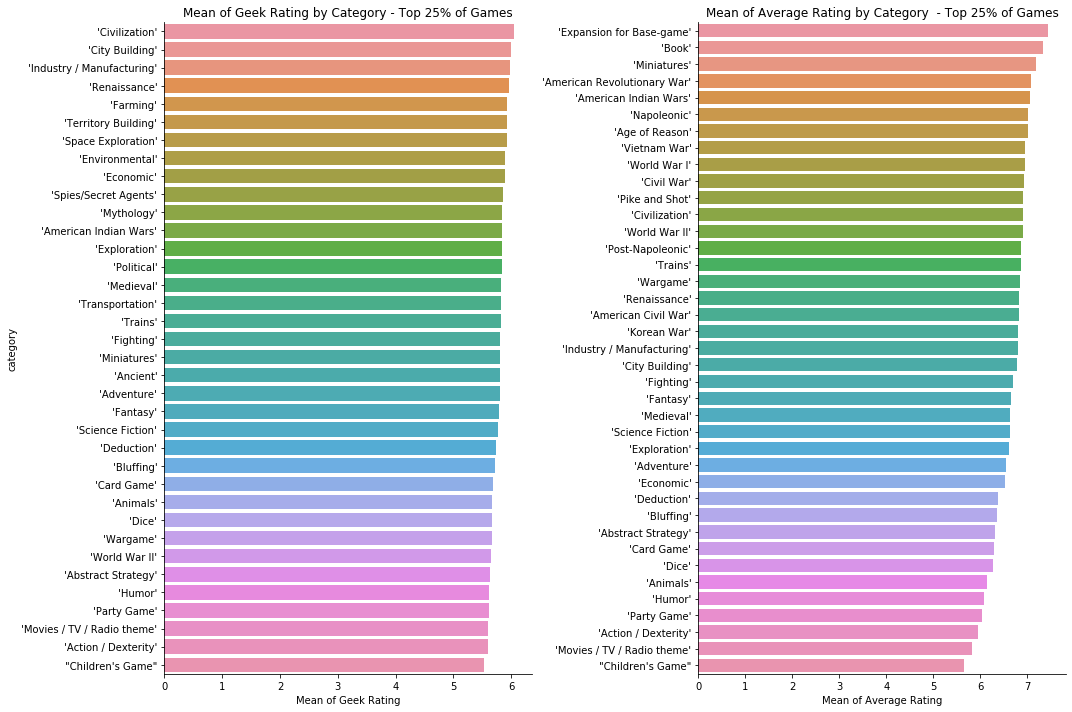

In [473]:
# there are too many labels to meaningfully visualize. Let's look at the top 25% of games.
cag_p75 = cat_avg_group.quantile(0.75)
cat_avg_group75 = cat_avg_group[(cat_avg_group > cag_p75).any(axis=1)]

cgg_p75 = cat_geek_group.quantile(0.75)
cat_geek_group75 = cat_geek_group[(cat_geek_group > cgg_p75).any(axis=1)]

_ = plt.figure(figsize=(15,10))
_ = plt.subplot(1,2,1)
_ = sns.barplot(y=cat_geek_group75.index ,x=cat_geek_group75['mean'], data=cat_geek_group75, order=cat_geek_group75.sort_values('mean', ascending=False).index, orient='h')
_ = plt.xlabel('Mean of Geek Rating')
_ = plt.title('Mean of Geek Rating by Category - Top 25% of Games')
_ = sns.despine()

_ = plt.subplot(1,2,2)
_ = sns.barplot(y=cat_avg_group75.index ,x=cat_avg_group75['mean'], data=cat_avg_group75, order=cat_avg_group75.sort_values('mean', ascending=False).index, orient='h')
_ = plt.xlabel('Mean of Average Rating')
_ = plt.ylabel('')
_ = plt.title('Mean of Average Rating by Category  - Top 25% of Games')
_ = sns.despine()

plt.tight_layout()

This shows some interesting differences. For instance 'Expansion for Base-game' and 'Book' are the top categories on Average Rating by Category, but aren't even present in Geek Raiting by Category. Additionally, many war-type game categories are missing from Geek Raiting by Category. The categories in both are:

In [511]:
geek_rating_cat = {item for item in (cat_geek_group75.index.to_list())}
avg_rating_cat = {item for item in (cat_avg_group75.index.to_list())}
geek_rating_cat.intersection(avg_rating_cat)

{'"Children\'s Game"',
 "'Abstract Strategy'",
 "'Action / Dexterity'",
 "'Adventure'",
 "'American Indian Wars'",
 "'Animals'",
 "'Bluffing'",
 "'Card Game'",
 "'City Building'",
 "'Civilization'",
 "'Deduction'",
 "'Dice'",
 "'Economic'",
 "'Exploration'",
 "'Fantasy'",
 "'Fighting'",
 "'Humor'",
 "'Industry / Manufacturing'",
 "'Medieval'",
 "'Miniatures'",
 "'Movies / TV / Radio theme'",
 "'Party Game'",
 "'Renaissance'",
 "'Science Fiction'",
 "'Trains'",
 "'Wargame'",
 "'World War II'"}

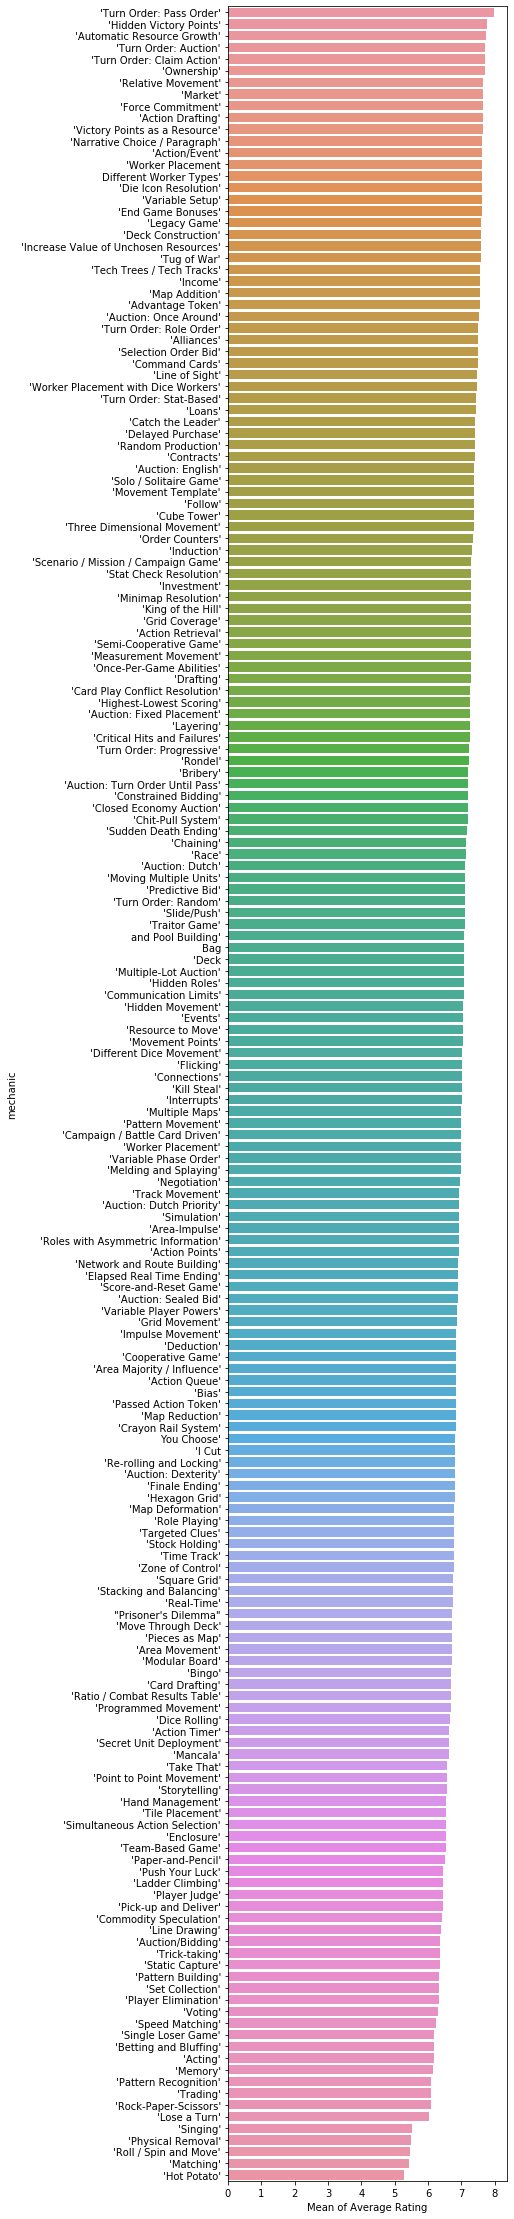

In [435]:
_ = plt.figure(figsize=(5,40))
#_ = plt.subplot(1,2,1)
#_ = sns.barplot(y=cat_geek_group.index ,x=cat_geek_group['mean'], data=cat_geek_group, order=cat_geek_group.sort_values('mean', ascending=False).index, orient='h')
#_ = plt.xlabel('Mean of Geek Rating')

#_ = plt.subplot(1,2,2)
_ = sns.barplot(y=mech_avg_group.index ,x=mech_avg_group['mean'], data=mech_avg_group, order=mech_avg_group.sort_values('mean', ascending=False).index, orient='h')
_ = plt.xlabel('Mean of Average Rating')

#plt.tight_layout()

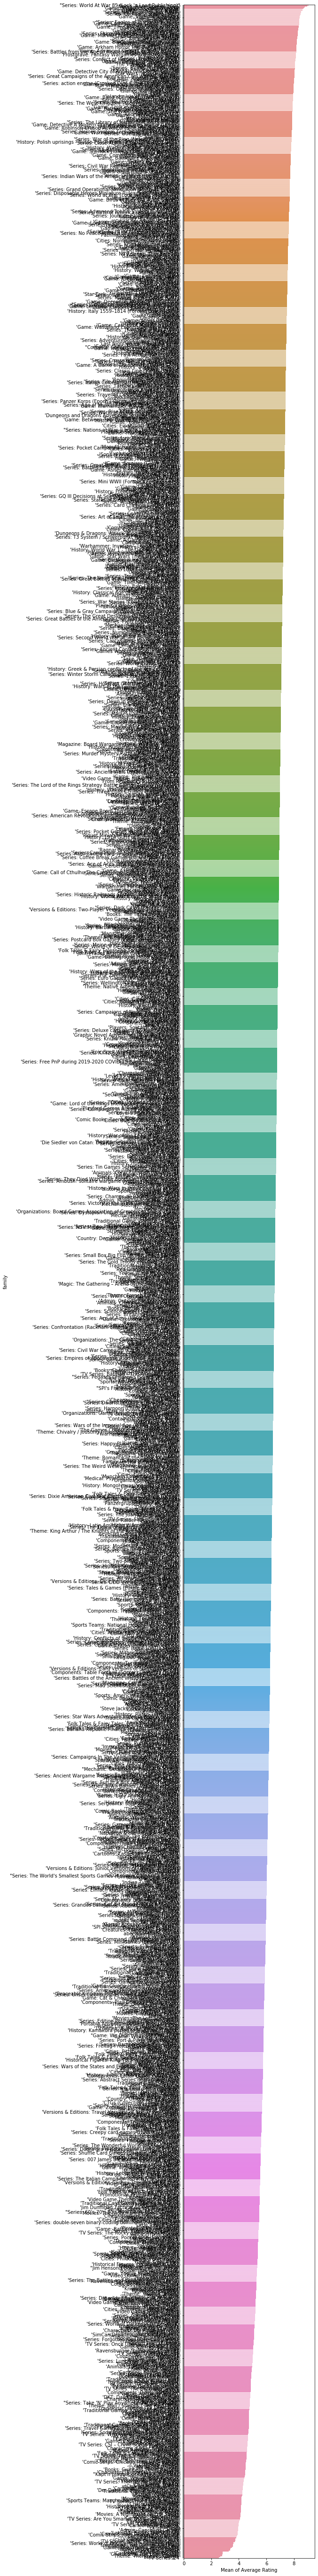

In [430]:
_ = plt.figure(figsize=(5,100))
#_ = plt.subplot(1,2,1)
#_ = sns.barplot(y=cat_geek_group.index ,x=cat_geek_group['mean'], data=cat_geek_group, order=cat_geek_group.sort_values('mean', ascending=False).index, orient='h')
#_ = plt.xlabel('Mean of Geek Rating')

#_ = plt.subplot(1,2,2)
_ = sns.barplot(y=fam_avg_group.index ,x=fam_avg_group['mean'], data=fam_avg_group, order=fam_avg_group.sort_values('mean', ascending=False).index, orient='h')
_ = plt.xlabel('Mean of Average Rating')

#plt.tight_layout()